# Fine-Grained Curriculum Design from Dataset Aggregation Perspective

In [39]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../')
import scriptinit
import numpy as np
import numpy.random as npr
import numpy.linalg as npla
from matplotlib.pyplot import *
from pyrl.algorithms.uvfa import *
from pyrl.algorithms.valueiter import *
from pyrl.tasks.gridworld import *
from pyrl.algorithms.nn import *
from pyrl.agents.agent import *
from pyrl.agents.multitask import *
from pyrl.algorithms.multitask import *
import pyrl.agents.arch as arch
from pyrl.prob import *
from pyrl.utils import *
from pyrl.evaluate import *

In [40]:
def showV(v):
    imshow(v.reshape(H, W), interpolation='none')
    print v
    
def showExperience(agent):
    task_types = set(agent.experience_task)
    task_percent = dict()
    for task in task_types:
        task_percent[task] = sum([e == task for e in agent.experience_task])
#     total = sum(task_percent.values())
    total = 1.
    return {key: val / float(total) for (key, val) in task_percent.items()}

# World

[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]


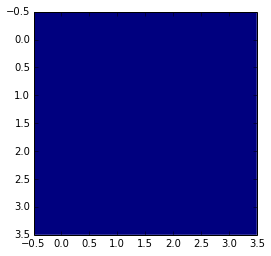

In [76]:
# world 1
H = W = 4
grid = np.zeros((H, W))
# grid[3:4, 3:4] = 1.
showV(grid)

In [77]:
tasks = generate_gridworlds_fixed_start_state(grid)
tasks_cv = prob.choice(sum(tasks.values(), []), 30, replace=False)
for key in tasks:
    random.shuffle(tasks[key])
# random.shuffle(all_tasks)
# tasks = all_tasks[:4] + all_tasks[-4:]

In [78]:
tasks

{1: [(0, 1) -> (1, 1),
  (1, 3) -> (2, 3),
  (2, 2) -> (2, 3),
  (2, 1) -> (2, 2),
  (1, 1) -> (0, 1),
  (3, 3) -> (3, 2),
  (1, 2) -> (1, 1),
  (2, 1) -> (3, 1),
  (0, 0) -> (1, 0),
  (0, 1) -> (0, 2),
  (1, 1) -> (1, 0),
  (1, 0) -> (0, 0),
  (1, 0) -> (2, 0),
  (2, 0) -> (2, 1),
  (3, 0) -> (2, 0),
  (3, 1) -> (2, 1),
  (1, 1) -> (1, 2),
  (0, 1) -> (0, 0),
  (0, 3) -> (0, 2),
  (1, 0) -> (1, 1),
  (2, 0) -> (3, 0),
  (3, 3) -> (2, 3),
  (2, 2) -> (3, 2),
  (0, 3) -> (1, 3),
  (2, 3) -> (1, 3),
  (0, 2) -> (1, 2),
  (0, 2) -> (0, 1),
  (2, 3) -> (2, 2),
  (1, 2) -> (0, 2),
  (1, 3) -> (1, 2),
  (2, 1) -> (2, 0),
  (3, 1) -> (3, 2),
  (3, 0) -> (3, 1),
  (1, 2) -> (2, 2),
  (2, 2) -> (2, 1),
  (0, 0) -> (0, 1),
  (3, 1) -> (3, 0),
  (2, 3) -> (3, 3),
  (3, 2) -> (2, 2),
  (1, 1) -> (2, 1),
  (1, 2) -> (1, 3),
  (0, 2) -> (0, 3),
  (2, 2) -> (1, 2),
  (1, 3) -> (0, 3),
  (3, 2) -> (3, 1),
  (3, 2) -> (3, 3),
  (2, 0) -> (1, 0),
  (2, 1) -> (1, 1)],
 2: [(2, 3) -> (2, 1),
  (3, 1) -> (

In [79]:
tasks_cv

[(0, 0) -> (3, 2),
 (0, 2) -> (3, 1),
 (3, 2) -> (1, 2),
 (0, 1) -> (0, 3),
 (1, 2) -> (1, 0),
 (0, 0) -> (2, 1),
 (1, 1) -> (2, 1),
 (1, 3) -> (2, 0),
 (1, 3) -> (0, 2),
 (2, 3) -> (0, 0),
 (2, 1) -> (0, 0),
 (0, 0) -> (1, 3),
 (3, 1) -> (3, 2),
 (2, 3) -> (0, 1),
 (0, 0) -> (2, 2),
 (0, 2) -> (3, 3),
 (0, 1) -> (2, 3),
 (2, 1) -> (3, 3),
 (0, 0) -> (1, 2),
 (3, 1) -> (1, 0),
 (0, 0) -> (1, 0),
 (0, 2) -> (1, 1),
 (3, 3) -> (2, 1),
 (3, 2) -> (0, 1),
 (3, 3) -> (1, 0),
 (1, 3) -> (3, 1),
 (0, 3) -> (0, 1),
 (3, 1) -> (1, 2),
 (3, 0) -> (2, 1),
 (3, 1) -> (2, 2)]

In [80]:
# neural network architecture.
# shared weights between state and goal due to symmetry.
def two_stream_arch(states, input_dim=H * W, output_dim=4):
    params = []
    ## agent.
    H_AGENT_DIM1 = 16
    fc_agent1 = layers.FullyConnected(input_dim, H_AGENT_DIM1, activation='relu')
    h_agent1 = fc_agent1(states[:, :input_dim])
    h_goal1 = fc_agent1(states[:, input_dim:2*input_dim]) # shared weights.
    ## combine them all!
    v_joint = T.concatenate([h_agent1, h_goal1], axis=1)
    H_JOINT_DIM = 64
    fc_joint = layers.FullyConnected(2 * H_AGENT_DIM1, H_JOINT_DIM, activation='relu')
    linear_layer = layers.FullyConnected(H_JOINT_DIM, output_dim, activation=None)
    
    output = linear_layer(fc_joint(v_joint))
    
    model = {
        'fc_agent1': fc_agent1,
        'fc_joint': fc_joint,
        'linear_layer': linear_layer
    }
    return (output, model)




In [81]:
def layered_training(dqn, learn_func, num_epochs = 1):
    for key in tasks:
        for ei in range(num_epochs):
            learn_func(dqn, tasks[key])
    
            

# Sequential Learning on Increasingly Difficult Tasks

In [74]:
dqn = DQN(tasks[1][0], two_stream_arch)
def learn_func(dqn, some_tasks):
    learner = SingleLearnerSequential(dqn, some_tasks, 
                               lr=1e-4, memory_size=250)
    train_performances = []
    for it in range(100):
        learner.run(num_epochs = 1, num_episodes = 1)
#         last_task_performance = np.zeros(len(tasks_cv))
#         for ti in range(len(tasks_cv)):
#             last_task_performance[ti] = expected_reward_tabular_normalized(dqn, tasks_cv[ti], tol=1e-4)
#         train_performances.append(np.mean(last_task_performance))
        last_task_performance = np.zeros(len(some_tasks))
        for ti in range(len(some_tasks)):
            last_task_performance[ti] = reward_tabular_normalized([some_tasks[ti].start_state], dqn, some_tasks[ti], tol=1e-4)
        train_performances.append(np.mean(last_task_performance))
        print 'it', it, 'train_performances', train_performances[-1]
        print 'task id', learner.t % len(some_tasks), 'rewards', last_task_performance
        print 'task percentage', showExperience(learner.deepQlearn)
        print
    plot(train_performances)

# layered_training(dqn, learn_func, num_epochs=1)
learn_func(dqn, tasks[1])

TypeError: run() got an unexpected keyword argument 'num_episodes'

In [49]:
dqn = DQN(tasks[1][0], two_stream_arch)
def learn_func(dqn, some_tasks):
    learner = SingleLearnerSequential(dqn, some_tasks, 
                               lr=1e-3, memory_size=10000)
    train_performances = []
    for it in range(100):
        learner.run(num_epochs = 1, num_episodes = 1)
#         last_task_performance = np.zeros(len(tasks_cv))
#         for ti in range(len(tasks_cv)):
#             last_task_performance[ti] = expected_reward_tabular_normalized(dqn, tasks_cv[ti], tol=1e-4)
#         train_performances.append(np.mean(last_task_performance))
        last_task_performance = np.zeros(len(some_tasks))
        for ti in range(len(some_tasks)):
            last_task_performance[ti] = reward_tabular_normalized([some_tasks[ti].start_state], dqn, some_tasks[ti], tol=1e-4)
        train_performances.append(np.mean(last_task_performance))
        print 'it', it, 'train_performances', train_performances[-1]
        print 'task id', learner.t % len(some_tasks), 'rewards', last_task_performance
        print 'task percentage', showExperience(learner.deepQlearn)
        print
    plot(train_performances)

# layered_training(dqn, learn_func, num_epochs=1)
learn_func(dqn, tasks[1])

TypeError: run() got an unexpected keyword argument 'num_episodes'

**Note** This explains why random policy performs worse than sequential policy. For late comers, the agent is going to collect less training example on the task than say the first task. So more learning is done for tasks that come ealier.

# Curriculum Training

it 0 train_performances 0.421498405479
task id 1 rewards [ 0.20703098  0.94622452  0.63719533  0.59357727  0.31155068  0.47727953
  0.09808074  0.62709242  0.06887655  0.57115363  0.07242957  0.05887926
  0.08081787  0.89941128  0.08385307  0.08421226  0.93432944  0.06171921
  0.2856608   0.85779992  0.19594426  0.44725863  0.19456367  0.36957522
  0.93641885  0.14857325  0.11102091  0.4111609   0.08225114  0.26771393
  0.31316333  0.96289332  0.93301609  0.74086381  0.13873847  0.93073534
  0.06746828  0.16588206  0.19326993  0.14625644  0.65791369  0.94824331
  0.26387031  0.8766856   0.22157114  0.96354232  0.15831326  0.42784167]
task percentage {(0, 1) -> (1, 1): 505.0}

it 1 train_performances 0.421498405479
task id 2 rewards [ 0.20703098  0.94622452  0.63719533  0.59357727  0.31155068  0.47727953
  0.09808074  0.62709242  0.06887655  0.57115363  0.07242957  0.05887926
  0.08081787  0.89941128  0.08385307  0.08421226  0.93432944  0.06171921
  0.2856608   0.85779992  0.19594426  0

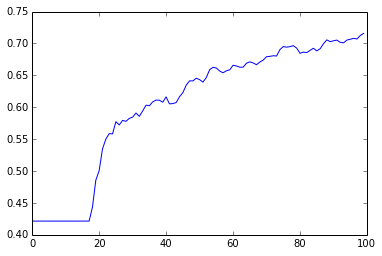

In [82]:
dqn = DQN(tasks[1][0], two_stream_arch)
def learn_func(dqn, some_tasks):
    learner = SingleLearnerSequential(dqn, some_tasks, 
                               lr=1e-4, memory_size=10000)
    train_performances = []
    for it in range(100):
        learner.run(num_epochs = 1, budget = 500)
#         last_task_performance = np.zeros(len(tasks_cv))
#         for ti in range(len(tasks_cv)):
#             last_task_performance[ti] = expected_reward_tabular_normalized(dqn, tasks_cv[ti], tol=1e-4)
#         train_performances.append(np.mean(last_task_performance))
        last_task_performance = np.zeros(len(some_tasks))
        for ti in range(len(some_tasks)):
            last_task_performance[ti] = reward_tabular_normalized([some_tasks[ti].start_state], dqn, some_tasks[ti], tol=1e-4)
        train_performances.append(np.mean(last_task_performance))
        print 'it', it, 'train_performances', train_performances[-1]
        print 'task id', learner.t % len(some_tasks), 'rewards', last_task_performance
        print 'task percentage', showExperience(learner.deepQlearn)
        print
    plot(train_performances)

# layered_training(dqn, learn_func, num_epochs=1)
learn_func(dqn, tasks[1])

it 0 train_performances 0.579608060295
task id 1 rewards [ 0.68084809  0.77357783  0.85910249  0.56638004  0.27010127  0.63975777
  0.89876055  0.74579301  0.71324617  0.72310642  0.37045678  0.66829957
  0.11046724  0.70692274  0.47954927  0.76251071  0.83480555  0.68063136
  0.71871953  0.75072241  0.56304565  0.60027918  0.17643913  0.49291292
  0.74345083  0.23308331  0.55780441  0.29402395  0.19677042  0.75446908
  0.35388473  0.71473317  0.54678471  0.53261914  0.6575108   0.78806393
  0.50709917  0.8439482   0.74528582  0.60721399  0.77824     0.60125479
  0.70330294  0.7083812   0.68792421  0.61949112  0.68454304  0.86231646
  0.67181267  0.14835137  0.33868514  0.73223128  0.8043489   0.21495899
  0.12794387  0.73775266  0.16199091  0.49480276  0.49378795  0.2927987
  0.21465929  0.3748437   0.57372198  0.41230566  0.87946783  0.69527663
  0.81937798  0.71559478]
task percentage {(2, 3) -> (2, 1): 551.0}

it 1 train_performances 0.579608060295
task id 2 rewards [ 0.68084809  0

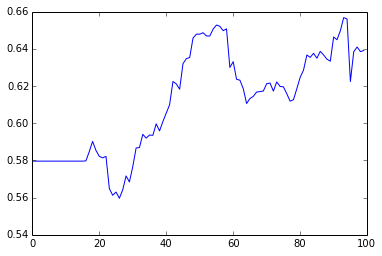

In [83]:
# start training level-2 tasks.
learn_func(dqn, tasks[2])


it 0 train_performances 0.529300151822
task id 1 rewards [ 0.69720928  0.22835326  0.49918858  0.7999679   0.6268419   0.56091878
  0.64391821  0.26976557  0.61650665  0.63845492  0.53414059  0.59120693
  0.18814351  0.29468141  0.60341907  0.32908729  0.57121415  0.45157731
  0.6586768   0.31765702  0.71306875  0.15953973  0.60510352  0.44095657
  0.15420074  0.50452425  0.70725063  0.6536765   0.66523686  0.52863602
  0.77247484  0.65374993  0.63682701  0.80773493  0.59855598  0.66203622
  0.52749035  0.65852357  0.11555274  0.64652283  0.65838634  0.57125176
  0.55830265  0.62104293  0.48797565  0.58669326  0.67740789  0.80626899
  0.44303435  0.57694027  0.14880138  0.68464318  0.69931147  0.26604508
  0.5208007   0.50193074  0.21114569  0.45268666  0.66643302  0.42803594
  0.49341437  0.62443743  0.33412161  0.52350726]
task percentage {(2, 3) -> (3, 1): 651.0}

it 1 train_performances 0.529300151822
task id 2 rewards [ 0.69720928  0.22835326  0.49918858  0.7999679   0.6268419   0

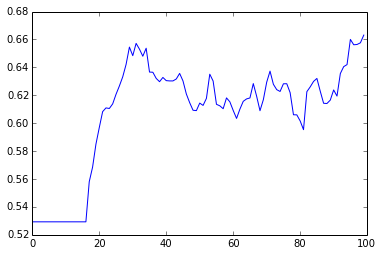

In [84]:
# start training level-3 tasks.
learn_func(dqn, tasks[3])



it 0 train_performances 0.612018768218
task id 1 rewards [ 0.5502901   0.66185828  0.63920757  0.74707197  0.48482449  0.47068595
  0.61819274  0.64056932  0.61557805  0.6425401   0.54002782  0.61030445
  0.60268091  0.6921818   0.62357379  0.5790995   0.61525121  0.47452259
  0.4931117   0.53551696  0.64144927  0.6926357   0.61016153  0.67675853
  0.63977656  0.78409618  0.54828193  0.63738292  0.52723939  0.70309824
  0.60516433  0.67522437  0.60519535  0.61914307  0.60265946  0.55462554
  0.64131226  0.65896647  0.61552315  0.60496717]
task percentage {(1, 3) -> (3, 1): 612.0}

it 1 train_performances 0.612018768218
task id 2 rewards [ 0.5502901   0.66185828  0.63920757  0.74707197  0.48482449  0.47068595
  0.61819274  0.64056932  0.61557805  0.6425401   0.54002782  0.61030445
  0.60268091  0.6921818   0.62357379  0.5790995   0.61525121  0.47452259
  0.4931117   0.53551696  0.64144927  0.6926357   0.61016153  0.67675853
  0.63977656  0.78409618  0.54828193  0.63738292  0.52723939  0

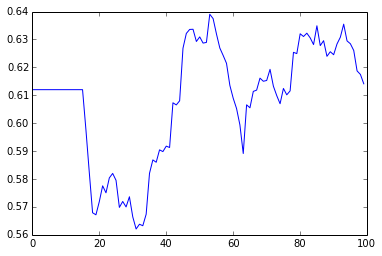

In [85]:
# start training level-4 tasks.
learn_func(dqn, tasks[4])

# Baseline.

it 0 train_performances 0.114854191212
task id 1 rewards [  2.04092259e-04   1.04062463e-02   3.48513409e-01   2.01682717e-02
   3.31189346e-01   1.35436595e-04   6.22740881e-02   4.86828861e-04
   5.27935561e-04   5.83643887e-03   2.80779106e-01   7.95165041e-02
   9.60062988e-04   4.28590974e-01   1.87341118e-01   1.78401242e-03
   2.53480539e-04   6.02287817e-05   7.49947539e-01   7.62915442e-02
   3.49153007e-01   9.34764158e-04   2.14193311e-01   1.37708331e-02
   7.62178373e-03   4.20342200e-01   4.27809159e-04   1.11826373e-02
   2.28631625e-01   1.73383521e-01   1.01793930e-03   7.07111136e-02
   3.09887019e-03   2.56619595e-02   5.44000604e-02   1.21791247e-03
   1.07728354e-03   1.22402311e-01   6.43666613e-04   3.09028376e-01]
task percentage {(1, 3) -> (3, 1): 502.0}

it 1 train_performances 0.114854191212
task id 2 rewards [  2.04092259e-04   1.04062463e-02   3.48513409e-01   2.01682717e-02
   3.31189346e-01   1.35436595e-04   6.22740881e-02   4.86828861e-04
   5.27935561e

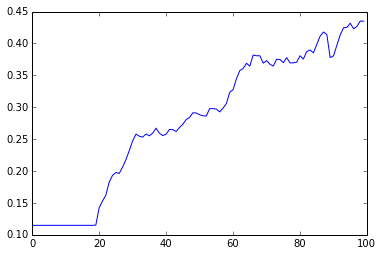

In [86]:
# learn on level-4 tasks directly.
dqn = DQN(tasks[1][0], two_stream_arch)
learn_func(dqn, tasks[4])